### Load packages

In [52]:
library(tidyverse)
library(ggthemes)
library(lme4)
library(lmerTest)
library(brms)
library(broom.mixed)
library(tidyboot)

In [75]:
d = read_csv('../results/csv/summary/human_accuracy_by_scenario.csv')
c = read_csv('../results/csv/summary/human_pairwiseCorrs_by_scenario.csv')
combined = left_join(c,d)


── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  obs_mean = col_double(),
  boot_mean = col_double(),
  ci_lb = col_double(),
  ci_ub = col_double(),
  pct_2.5 = col_double(),
  pct_97.5 = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  agent = col_character(),
  scenario = col_character(),
  corr_lb = col_double(),
  corr_med = col_double(),
  corr_ub = col_double()
)


Joining, by = c("agent", "scenario")



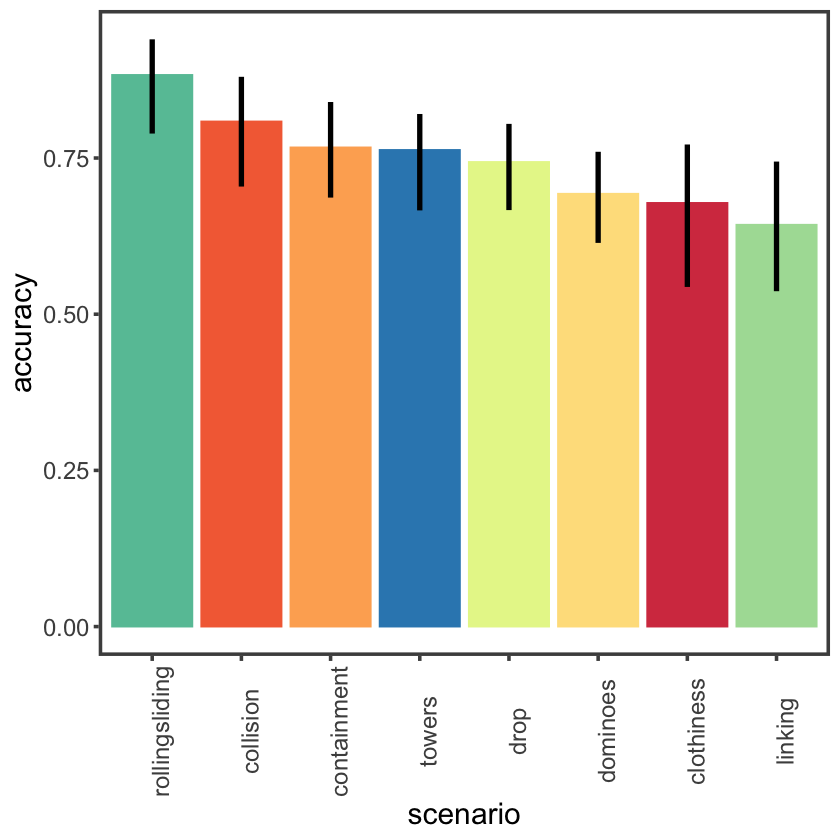

In [76]:
## accuracy bar plot with 2.5 and 97.5 percentile marked (THESE ARE NOT CONFIDENCE INTERVALS)
combined %>%
  ggplot(aes(x=reorder(scenario,-obs_mean), y=obs_mean, color=scenario, fill=scenario)) +
  geom_bar(stat='identity') +
  geom_errorbar(aes(ymin=pct_2.5, ymax = pct_97.5), width = 0, size = 1.5, color='black') + 
    theme_few() +
    xlab('scenario') +
    ylab('accuracy') +
    theme(text = element_text(size=18), 
          element_line(size=1), 
          element_rect(size=2, color="#00000"),
          axis.text.x = element_text(angle=90)) +
    theme(legend.position = "none") +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_accuracy_across_scenarios.pdf', width=12, height = 18, units='cm')

In [77]:
## TODO: add model bars


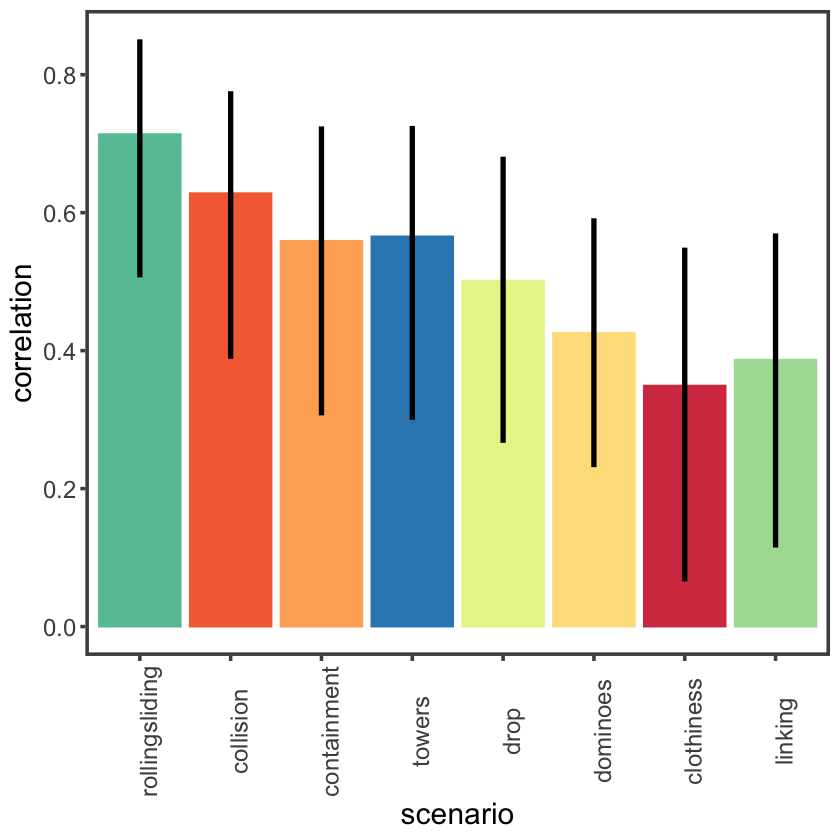

In [78]:
## TODO: human-model correlation
combined %>%
  ggplot(aes(x=reorder(scenario,-obs_mean), y=corr_med, color=scenario, fill=scenario)) +
  geom_bar(stat='identity') +
  geom_errorbar(aes(ymin=corr_lb, ymax = corr_ub), width = 0, size = 1.5, color='black') + 
    theme_few() +
    xlab('scenario') +
    ylab('correlation') +
    theme(text = element_text(size=18), 
          element_line(size=1), 
          element_rect(size=2, color="#00000"),
          axis.text.x = element_text(angle=90)) +
    theme(legend.position = "none") +
    scale_fill_brewer(palette="Spectral") + scale_color_brewer(palette="Spectral")

ggsave('../results/plots/human_pairwiseCorrs_across_scenarios.pdf', width=12, height = 18, units='cm')

In [79]:
## TODO: human-model kappa